# Sentimental Tweets Videos Games

L'objectif principal de ce projet est de déterminer si un type de jeu est perçu comme bon, mauvais ou neutre à partir d'un ensemble de tweets, en utilisant des modèles de traitement du langage naturel (NLP) ou de Machine Learning. <br>

Dans un premier temps, nous allons explorer et analyser le jeu de données pour mieux comprendre sa structure. Cela inclura des étapes de prétraitement des données visant à nettoyer les valeurs manquantes, éliminer les doublons et améliorer la qualité du contenu des tweets afin de mieux représenter le corpus. <br>

Ensuite, nous utiliserons une méthode de pondération des mots appelée TF-IDF (Term Frequency-Inverse Document Frequency). Cette méthode permettra d'identifier la fréquence des mots et leur importance relative pour chaque tweet. <br>

Une fois les données préparées, nous entraînerons différents modèles de Machine Learning à l'aide de la bibliothèque Scikit-learn. Ces modèles seront évalués pour identifier les plus performants à l'aide de techniques de validation croisée. <br>

Enfin, nous validerons les performances du modèle sélectionné sur un jeu de données différent. <br>

Par ailleurs, nous explorerons des outils d'interprétabilité pour analyser les prédictions du modèle. Cela nous permettra de comprendre et d'identifier les erreurs, que ce soit sur le jeu d'entraînement ou le jeu de test. <br>

https://www.kaggle.com/datasets/jp797498e/twitter-entity-sentiment-analysis (Lien de téléchargement de deux datasets) <br>

## Load librairies

*Commande pour installer toute les librairies*

!pip install -r requirements.txt

In [34]:
import pandas as pd
import numpy as np

import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt

import re
import nltk
from nltk.corpus import stopwords
nltk.download('punkt_tab')
nltk.download('stopwords')

from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from scipy.stats import randint

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\Vincent\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Vincent\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Lecture et exploration du dataset

Le jeu de données utilisé se compose de 4 types de colonnes : <br>

L'index de la catégorie <br>
La catégorie du jeu <br>
La catégorie du sentiment <br>
Le contenu du tweet <br>

#### Phase de Nettoyage des tweets

On va supprimer la colonne l'index de la catégorie qui nous serve pas pour le moment et puis de supprimer tout les valeurs manquants, les doublons
et de retirer tout les catégories qui ne provient pas les catégories sur les jeux vidéos...

Au total, on utilise 74000 de lignes de données à traiter et à la fin on aura environ 40000 lignes de données à traiter après le nettoyage

In [35]:
data_path = "data"

In [36]:
df = pd.read_csv(f"{data_path}/twitter_training.csv",names=["index_category", "game_category","sentiment_category","Tweet"])

In [37]:
df.head()

,index_category,game_category,sentiment_category,Tweet
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...


In [38]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74682 entries, 0 to 74681
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   index_category      74682 non-null  int64 
 1   game_category       74682 non-null  object
 2   sentiment_category  74682 non-null  object
 3   Tweet               73996 non-null  object
dtypes: int64(1), object(3)
memory usage: 2.3+ MB


In [39]:
df["sentiment_category"].describe()

count        74682
unique           4
top       Negative
freq         22542
Name: sentiment_category, dtype: object

In [40]:
print("Taille de données restant:", df.shape)

Taille de données restant: (74682, 4)


On supprime l'index_category la colonne qui nous serve pas pour le moment

In [41]:
df = df.drop(columns='index_category',axis=1)
df.head()

,game_category,sentiment_category,Tweet
0,Borderlands,Positive,im getting on borderlands and i will murder yo...
1,Borderlands,Positive,I am coming to the borders and I will kill you...
2,Borderlands,Positive,im getting on borderlands and i will kill you ...
3,Borderlands,Positive,im coming on borderlands and i will murder you...
4,Borderlands,Positive,im getting on borderlands 2 and i will murder ...


On observe qu'il y a 686 de valeurs manquants sur le Tweet

In [42]:
print(df.isnull().sum())

game_category           0
sentiment_category      0
Tweet                 686
dtype: int64


In [43]:
print("Avant la suppression des données manquantes: ",len(df))
df = df.dropna()
print("Après la suppression des données manquantes: ",len(df))

Avant la suppression des données manquantes:  74682
Après la suppression des données manquantes:  73996


In [44]:
df = df.drop_duplicates()
print("Taille de données restant:", df.shape)

Taille de données restant: (70958, 3)


Retirer les catégories qui sont exclues aux noms des jeux vidéos

In [45]:
exclude_categories = ['johnson&johnson', 'Amazon','Nvidia','PlayStation5(PS5)','Xbox(Xseries)','HomeDepot','Verizon','Facebook','Google','Microsoft']

df = df[~df['game_category'].isin(exclude_categories)]

Retirer la catégorie Irrelevant (car il y a pas assez de données pour effectuer l'analyse des sentiments) <br>
On se base uniquement sur 3 catégories sentiments (positive, négative et neutre)

In [46]:
df = df[df['sentiment_category'] != 'Irrelevant']

In [47]:
print("Taille de données restant:", df.shape)

Taille de données restant: (39588, 3)


In [48]:
df.head()

,game_category,sentiment_category,Tweet
0,Borderlands,Positive,im getting on borderlands and i will murder yo...
1,Borderlands,Positive,I am coming to the borders and I will kill you...
2,Borderlands,Positive,im getting on borderlands and i will kill you ...
3,Borderlands,Positive,im coming on borderlands and i will murder you...
4,Borderlands,Positive,im getting on borderlands 2 and i will murder ...


## Premiers Visualisations à déterminer

### Liste des noms de jeux

Voici la liste des catégories des jeux utilisés pour notre jeu de données

In [49]:
all_games_category = df['game_category'].unique()
print(all_games_category)

['Borderlands' 'CallOfDutyBlackopsColdWar' 'Overwatch' 'NBA2K' 'Dota2'
 'WorldOfCraft' 'CS-GO' 'AssassinsCreed' 'ApexLegends' 'LeagueOfLegends'
 'Fortnite' 'Hearthstone' 'Battlefield'
 'PlayerUnknownsBattlegrounds(PUBG)' 'FIFA' 'RedDeadRedemption(RDR)'
 'CallOfDuty' 'TomClancysRainbowSix' 'GrandTheftAuto(GTA)' 'MaddenNFL'
 'Cyberpunk2077' 'TomClancysGhostRecon']


In [50]:
all_sentiments = df['sentiment_category'].unique()
print(all_sentiments)

['Positive' 'Neutral' 'Negative']


Répartition des jeux par catégorie sur l'ensemble des tweets 

In [ ]:
counts_games = df['game_category'].value_counts().sort_index()

# Conversion de counts_games en DataFrame pour une utilisation facile avec Plotly
counts_games_df = counts_games.reset_index()
counts_games_df.columns = ['game_category', 'count']

# Création du graphique en barres
fig = px.bar(
    counts_games_df,
    x='game_category',
    y='count',
    title='Répartition des jeux par catégorie',
    labels={'game_category': 'Catégorie de jeu', 'count': 'Nombre de tweets'},
    text='count'  # Affiche les valeurs directement sur les barres
)

# Amélioration de l'apparence
fig.update_layout(xaxis_tickangle=-45, width=1200, height=500)  # Rotation des labels si nécessaire
fig.show()

In [52]:
# Calculate the percentage of each sentiment class
sentiment_percentage = df['sentiment_category'].value_counts(normalize=True) * 100

# Convert the calculated percentages into DataFrame for plotting
percentage_df = pd.DataFrame({'Sentiment': sentiment_percentage.index, 'Percentage': sentiment_percentage.values})

# Plot the bar plot with percentages visible
fig = px.bar(percentage_df, x='Sentiment', y='Percentage', text='Percentage',
             title="Percentage of Each Sentiment Class", labels={'Sentiment': 'Sentiment Class', 'Percentage': 'Percentage (%)'})
fig.update_traces(texttemplate='%{text:.2f}%', textposition='outside')
fig.update_layout(width=600, height=500)
fig.show()

In [53]:
positive_df = df[df.sentiment_category == "Positive"].copy()
negatif_df = df[df.sentiment_category == "Negative"].copy()
neutral_df = df[df.sentiment_category == "Neutral"].copy()
irrelevant_df = df[df.sentiment_category == "Irrelevant"].copy()

positive_df["nb_char"] = positive_df["Tweet"].apply(len)
negatif_df["nb_char"] = negatif_df["Tweet"].apply(len)
neutral_df["nb_char"] = neutral_df["Tweet"].apply(len)
irrelevant_df["nb_char"] = irrelevant_df["Tweet"].apply(len)

In [54]:
fig_hist_pos = px.histogram(positive_df, x="nb_char", title="Répartition du nombre de caractères dans les textes positifs")
fig_hist_pos.update_layout(width=800, height=500)

In [55]:
fig_hist_neg = px.histogram(negatif_df, x="nb_char", title="Répartition du nombre de caractères dans les textes négatives")
fig_hist_neg.update_layout(width=800, height=500)

In [56]:
fig_hist_neu = px.histogram(neutral_df, x="nb_char", title="Distribution of number of characters in neutral texts")
fig_hist_neu.update_layout(width=600, height=500)

In [57]:
fig_hist_neu = px.histogram(neutral_df, x="nb_char", title=" Distribution of number of characters in neutral texts")
fig_hist_neu.update_layout(width=600, height=500)

### Le coefficient de Gini obtenu vous permettra de répondre aux questions suivantes : <br>
 
Les sentiments sont-ils bien répartis entre les différentes catégories ? <br>
Y a-t-il une forte concentration dans une ou deux catégories spécifiques ? <br>

Si le coefficient de Gini est proche de 0, cela signifie que les sentiments sont assez équilibrés entre les différentes catégories (positif, neutre, négatif). <br>
Si le coefficient de Gini est proche de 1, cela signifie qu'il y a une grande concentration des sentiments dans une seule catégorie, et les autres sont peu représentées. <br>


In [58]:
# Fonction pour calculer le coefficient de Gini
def gini(x):
    total = 0
    for i, xi in enumerate(x[:-1], 1):
        total += np.sum(np.abs(xi - x[i:]))
    return total / (len(x)**2 * np.mean(x))

# Dataset pour la répartition des sentiments de chaque tweet
percentages = df['sentiment_category'].value_counts(normalize=True)

# Calcul du coefficient de Gini
gini_coefficient = gini(percentages)
print("Coefficient de Gini :", round(gini_coefficient,2))

Coefficient de Gini : 0.08


### Data preprocessing

In [59]:
english_stopwords = set(stopwords.words('english'))

def remove_emoji():
  regex_pattern = re.compile(pattern = "["    #Pattern pour enlever les emojis
          u"\U0001F600-\U0001F64F"  # emoticons
          u"\U0001F300-\U0001F5FF"  # symbols & pictographs
          u"\U0001F680-\U0001F6FF"  # transport & map symbols
          u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
          u"\U00002702-\U000027B0"
          u"\U00002702-\U000027B0"
          u"\U000024C2-\U0001F251"
          u"\U0001f926-\U0001f937"
          u"\U00010000-\U0010ffff"
          u"\u2640-\u2642" 
          u"\u2600-\u2B55"
          u"\u200d"
          u"\u23cf"
          u"\u23e9"
          u"\u231a"
          u"\ufe0f"  # dingbats
          u"\u3030"
                            "]+", flags = re.UNICODE)
  return regex_pattern


def clean_text(text):
    
    """
    On retire tout d'abord nettoyer les tweets qui ne pourront pas nous servir
    """
    text = text.lower()
    text = re.sub(r'{link}', '',text) #Remove links 
    text = re.sub(r"\[video\]", '',text) #Remove videos
    text = re.sub(r'&[a-z]+;', '',text) #Remove HTML references

    text = re.sub(r'@\w+', '', text) #Remove mention
    text = re.sub(r'#\w+', '', text) #Remove hashtag

    text = re.sub(r'\d+', '', text) #Remove numbers 
    text = re.sub(r'http\S+', '',text) #Remove HTML
    text = re.sub(r'www\S+', '',text) #Remove HTML
    text = re.sub(r'[^\w\s]+',' ',text) #Remove ponctuation et apostrophes
    text = re.sub(r'\s+',' ', text) #Remove new line characters
    text = re.sub(r'[^\w\s]+',' ',text) #Remove ponctuation et apostrophes
    text = re.sub(remove_emoji(),'',text)  #Remove les emojis

    """
    Puis on souhaitera de transformer les mots courants vers des mots plus expressives en anglais
    """
    text = re.sub(r"won\'t", "would not", text)
    text = re.sub(r"im", "i am", text)
    text = re.sub(r"Im", "I am", text)
    text  = re.sub(r"can\'t", "can not", text)
    text  = re.sub(r"don\'t", "do not", text)
    text  = re.sub(r"shouldn\'t", "should not", text)
    text  = re.sub(r"needn\'t", "need not", text)
    text  = re.sub(r"hasn\'t", "has not", text)
    text  = re.sub(r"haven\'t", "have not", text)
    text  = re.sub(r"weren\'t", "were not", text)
    text  = re.sub(r"mightn\'t", "might not", text )
    text  = re.sub(r"didn\'t", "did not", text )
    text  = re.sub(r"n\'t", " not", text )
    text  = re.sub(r"\'re", " are", text )
    text  = re.sub(r"\'s", " is", text )
    text  = re.sub(r"\'d", " would", text )
    text  = re.sub(r"\'ll", " will", text )
    text  = re.sub(r"\'t", " not", text )
    text  = re.sub(r"\'ve", " have", text )
    text  = re.sub(r"\'m", " am", text )
    
    # Tokenize the text
    tokens = nltk.word_tokenize(text)

    # Remove stopwords from the tokenized text
    filtered_tokens = [word for word in tokens if word.lower() not in english_stopwords]

    # Join the filtered tokens back into a single string
    filtered_text = ' '.join(filtered_tokens)

    return filtered_text

df['tweet_clean'] = df['Tweet'].apply(clean_text)

In [60]:
df.head()

,game_category,sentiment_category,Tweet,tweet_clean
0,Borderlands,Positive,im getting on borderlands and i will murder yo...,getting borderlands murder
1,Borderlands,Positive,I am coming to the borders and I will kill you...,coming borders kill
2,Borderlands,Positive,im getting on borderlands and i will kill you ...,getting borderlands kill
3,Borderlands,Positive,im coming on borderlands and i will murder you...,coming borderlands murder
4,Borderlands,Positive,im getting on borderlands 2 and i will murder ...,getting borderlands murder


### Feature Engineering: TF-IDF (Term-Frequency Inverse Document Frequency)

L'objectif ici est d'identifier les vocabulaires les plus importants pour chaque type de jeu. Pour ce faire, nous allons associer le nom du jeu à celui qui correspond le mieux, afin d'analyser la visibilité des opinions exprimées dans les tweets.

In [61]:
words_to_remove = ['com', 'ti', 'borderlands', 'redemption','red','dead','creed','twitter','unk','duty','gta','call','tv','get','ame','one','pic','got']

vectorizer = TfidfVectorizer(
    max_features = 2000,
    stop_words=words_to_remove, 
    max_df=0.8, 
    min_df=5
)
X = vectorizer.fit_transform(df['tweet_clean'])

In [62]:
print("Vocab size: ", len(vectorizer.vocabulary_))
print("Vocab", vectorizer.vocabulary_)

Vocab size:  2000
Vocab {'getting': np.int64(735), 'murder': np.int64(1154), 'coming': np.int64(339), 'kill': np.int64(937), 'spent': np.int64(1635), 'hours': np.int64(850), 'making': np.int64(1063), 'something': np.int64(1613), 'fun': np.int64(715), 'know': np.int64(948), 'huge': np.int64(857), 'fan': np.int64(624), 'favorite': np.int64(635), 'characters': np.int64(290), 'decided': np.int64(432), 'make': np.int64(1061), 'pc': np.int64(1260), 'original': np.int64(1233), 'amage': np.int64(48), 'made': np.int64(1054), 'enjoy': np.int64(555), 'couple': np.int64(382), 'picture': np.int64(1275), 'compared': np.int64(348), 'rhandlerr': np.int64(1445), 'rock': np.int64(1457), 'hard': np.int64(800), 'la': np.int64(955), 'powerful': np.int64(1320), 'handsome': np.int64(792), 'xbox': np.int64(1979), 'dlvr': np.int64(487), 'live': np.int64(1013), 'music': np.int64(1155), 'like': np.int64(999), 'de': np.int64(426), 'first': np.int64(665), 'session': np.int64(1540), 'long': np.int64(1027), 'actuall

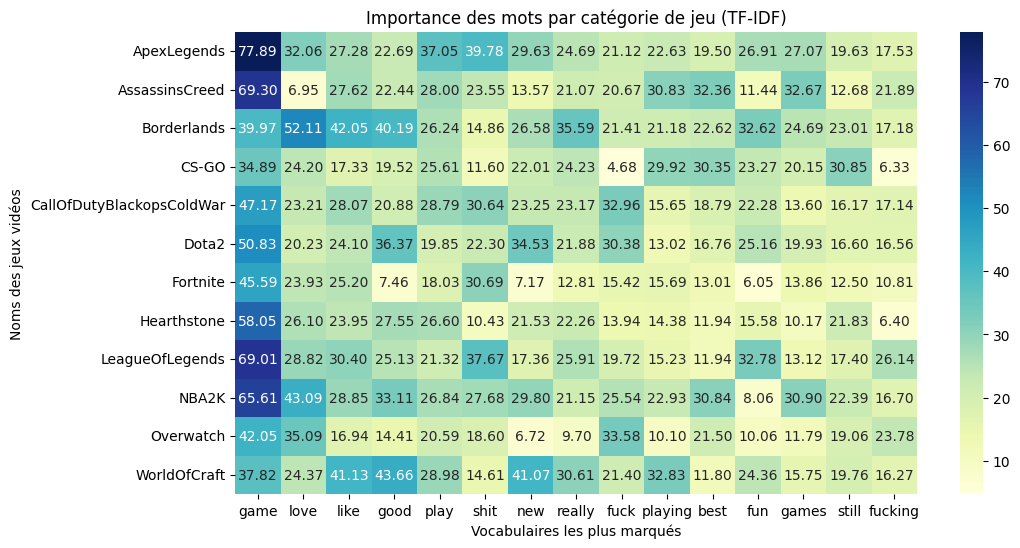

In [63]:
tfidf_matrix = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())

# Ajouter la colonne `game_category` au TF-IDF matrix
tfidf_matrix['game_category'] = df['game_category']

# Étape 2 : Agrégation par jeu
tfidf_grouped = tfidf_matrix.groupby('game_category').sum()

# Étape 3 : Sélection des mots les plus importants (optionnel)
top_words = tfidf_grouped.sum(axis=0).sort_values(ascending=False).head(15).index
tfidf_grouped_top = tfidf_grouped[top_words]

# Étape 4 : Création de la heatmap
plt.figure(figsize=(11, 6))
sns.heatmap(tfidf_grouped_top, cmap="YlGnBu", annot=True, fmt=".2f")
plt.title("Importance des mots par catégorie de jeu (TF-IDF)")
plt.xlabel("Vocabulaires les plus marqués")
plt.savefig("Best_Vocabulary_sentimental_by_game.png")
plt.ylabel("Noms des jeux vidéos")
plt.show()

## Entrainement des modèles de Machine Learning

#### Process Encodage des catégories de sentiments

In [64]:
# Encodage des catégories
sentiments = LabelEncoder()
df['sentiment_category_encoded'] = sentiments.fit_transform(df['sentiment_category'])
y = df['sentiment_category_encoded']

# Division des données
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

### Validation croisée pour déterminer la meilleure performance du modèle
Derniers relevés pour le choix du modèle:

Logistic Regression <br>
Cross-validation scores: [0.72, 0.72, 0.73, 0.72, 0.72] <br>
Mean cross-validation score: 0.72 <br>
Test score: 0.74 <br>

Random Forest <br>
Cross-validation scores: [0.86, 0.85, 0.85, 0.85, 0.85] <br>
Mean cross-validation score: 0.85  <br>
Test score: 0.87 <br>

MultinomialNB
Cross-validation scores: [0.7, 0.69, 0.7, 0.69, 0.69] <br>
Mean cross-validation score: 0.7 <br>
Test score: 0.7 <br>

In [ ]:
# Initialize classifiers
classifiers = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(),
    "MultinomialNB": MultinomialNB()
}

# Train and evaluate classifiers with cross-validation
for clf_name, clf in classifiers.items():
    print(clf_name)
    # Perform cross-validation
    cv_scores = cross_val_score(clf, X_train, y_train, cv=5, scoring="accuracy")
    # Convertir en floats natifs et arrondir à 2 décimales
    cv_scores_rounded = [round(float(score), 2) for score in cv_scores]  
    print(f"Cross-validation scores: {cv_scores_rounded}")
    print(f"Mean cross-validation score: {round(float(cv_scores.mean()), 2)}")  # Arrondir la moyenne

    # Fit the classifier on the entire training set
    clf.fit(X_train, y_train)

    # Evaluate the classifier on the test set
    test_score = clf.score(X_test, y_test)
    print(f"Test score: {round(float(test_score), 2)}\n")  # Arrondir le score test

Logistic Regression
Cross-validation scores: [0.72, 0.72, 0.73, 0.72, 0.72]
Mean cross-validation score: 0.72
Test score: 0.74

Random Forest


### Validation croisée alternée par RandomizedSearchCV pour déterminer les meilleurs hyperparamètres

In [225]:
# Définir les hyperparamètres à tester
param_distributions = {
    'n_estimators': randint(100, 200),  # Distribution pour le nombre d'arbres
    'max_depth': [None, 6],            # Valeurs fixes possibles
    'min_samples_split': randint(2, 4),  # Distribution pour le nombre minimal d'échantillons
    'min_samples_leaf': randint(1, 3)    # Distribution pour les feuilles
}

# Instanciation du modèle
rf_model = RandomForestClassifier()

# RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=rf_model,
    param_distributions=param_distributions,
    n_iter=10,                 # Nombre d'échantillons aléatoires à tester
    scoring='accuracy',        # Métrique d'évaluation sur l'accuracy
    cv=5,                      # Validation croisée avec 5 folds
    random_state=42,           # Pour la reproductibilité
    n_jobs=2                   # Utilisation de tous les cœurs disponibles
)

# Entraînement de RandomizedSearchCV
random_search.fit(X_train, y_train)

# Obtenir les meilleurs paramètres et le meilleur score
best_params = random_search.best_params_
best_score = random_search.best_score_

print("Best Parameters:", best_params)
print("Best Score:", round(best_score,2))

Best Parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 141}
Best Score: 0.85


In [228]:
# Modèle
model = RandomForestClassifier(**best_params)
model.fit(X_train, y_train)

# Prédictions
y_pred = model.predict(X_test)

# Rapport de classification
print(classification_report(y_test, y_pred, target_names=sentiments.classes_))

              precision    recall  f1-score   support

    Negative       0.89      0.89      0.89      4553
     Neutral       0.90      0.79      0.84      3113
    Positive       0.83      0.91      0.87      4211

    accuracy                           0.87     11877
   macro avg       0.88      0.86      0.87     11877
weighted avg       0.87      0.87      0.87     11877



In [229]:
# Exemple de tweets à prédire
new_tweets = [
    # Positive
    "I love playing Call of Duty, the action is incredible!",
    "Borderlands 3 is such an amazing game, highly recommended!",
    # Negative
    "Dota2's community is so toxic, it's hard to enjoy the game sometimes.",
    "Cyberpunk2077 still has bugs even after all these patches.",
    # Neutral
    "AssassinsCreed's open worlds are impressive, but they can feel overwhelming.",
    "Thinking about trying out Cyberpunk 2077; heard mixed reviews. #Cyberpunk2077",
]

# Vectoriser les nouveaux tweets
new_tweets_tfidf = vectorizer.transform(new_tweets)

# Faire les prédictions
#predicted_sentiments = model_1.predict(new_tweets_tfidf)
predicted_sentiments = model.predict(new_tweets_tfidf)

# Afficher les résultats
for tweet, sentiment in zip(new_tweets, predicted_sentiments):
    sentiment_class = sentiments.inverse_transform([sentiment])[0]
    print(f"Tweet: {tweet}")
    print(f"Predicted Sentiment: {sentiment} = {sentiment_class}")

Tweet: I love playing Call of Duty, the action is incredible!
Predicted Sentiment: 2 = Positive
Tweet: Borderlands 3 is such an amazing game, highly recommended!
Predicted Sentiment: 2 = Positive
Tweet: Dota2's community is so toxic, it's hard to enjoy the game sometimes.
Predicted Sentiment: 0 = Negative
Tweet: Cyberpunk2077 still has bugs even after all these patches.
Predicted Sentiment: 0 = Negative
Tweet: AssassinsCreed's open worlds are impressive, but they can feel overwhelming.
Predicted Sentiment: 0 = Negative
Tweet: Thinking about trying out Cyberpunk 2077; heard mixed reviews. #Cyberpunk2077
Predicted Sentiment: 1 = Neutral
